# **GRUPO 1** - Trabajo Práctico Nuestras Caras

**Integrantes:**

*   Noelia Mengoni
*   Bárbara Noelia Rey
*   María Guadalupe Salgero









## **Preparar el entorno en Google Colab**

En esta sección se configura el entorno de trabajo para desarrollar el proyecto en Google Colab. Se monta Google Drive para acceder a archivos almacenados, se definen rutas base y se crean carpetas necesarias para guardar resultados, modelos o salidas del entrenamiento.

In [2]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Cargar las librerias que vamos a utilizar**

Se importan las librerías requeridas para el análisis, incluyendo herramientas para manipulación y visualización de datos, procesamiento de imágenes, reducción de dimensionalidad y evaluación de modelos. Esta etapa garantiza que el entorno cuente con todas las funcionalidades necesarias antes de iniciar el procesamiento.

In [3]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.6 MB/s eta 0:00:00


In [4]:
import polars as pl
import numpy as np
import math
from typing import Optional, Tuple, Dict, List
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython import display
import time
import os
import pickle
from functools import reduce
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import cv2
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pandas as pd

## **Cargar modelo DNN para la detección de caras**

En esta parte del proyecto se configura y carga automáticamente un modelo preentrenado que permite detectar rostros en imágenes. Para ello, se establecen las rutas donde deben guardarse los archivos del modelo y se verifica si ya están disponibles en el entorno; si no, se descargan desde fuentes oficiales. Luego, se carga ese modelo utilizando herramientas de OpenCV, dejándolo listo para identificar las caras dentro de las fotos que se analizarán más adelante en el proyecto.


In [5]:
# Cargar el modelo DNN para detección de caras
MODELO_DIR = "/content/drive/MyDrive/DMA_Eigenfaces/modelos/dnn"
PROTOTXT_PATH = os.path.join(MODELO_DIR, "deploy.prototxt")
CAFFEMODEL_PATH = os.path.join(MODELO_DIR, "res10_300x300_ssd_iter_140000.caffemodel")

def verificar_y_descargar_modelos():
    os.makedirs(MODELO_DIR, exist_ok=True)
    if not os.path.exists(PROTOTXT_PATH):
        !wget -q -O "{PROTOTXT_PATH}" https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
    if not os.path.exists(CAFFEMODEL_PATH):
        !wget -q -O "{CAFFEMODEL_PATH}" https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

def cargar_face_detector() -> cv2.dnn_Net:
    verificar_y_descargar_modelos()
    net = cv2.dnn.readNetFromCaffe(PROTOTXT_PATH, CAFFEMODEL_PATH)
    return net

## **Detección de rostros en imágenes**

Esta sección define una función que detecta automáticamente un rostro dentro de una imagen utilizando los modelos DNN mencionados previamente. Primero verifica que la imagen sea válida y luego la convierte a un formato compatible con el modelo (blob). A continuación, se ejecuta la detección y se recorren todos los resultados encontrados. De todas las detecciones posibles, la función selecciona la de mayor confianza que supere un umbral mínimo predefinido. Si encuentra una detección válida, devuelve las coordenadas del rostro en formato (x1, y1, x2, y2); si no hay ninguna detección confiable, devuelve None.

In [6]:
def detectar_cara_dnn(img: np.ndarray, net: cv2.dnn_Net, confidence_threshold: float) -> Optional[Tuple[int, int, int, int]]:
    """
    Detecta una cara y devuelve las coordenadas de la mejor detección como (x1, y1, x2, y2).
    No realiza recortes, ni cambios de color, ni resize.
    """
    if img is None:
        return None

    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    if detections.shape[2] == 0:
        return None

    best_conf, best_box = 0, None
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf > best_conf and conf > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            best_box = box.astype("int")
            best_conf = conf

    if best_box is None:
        return None

    x1, y1, x2, y2 = best_box
    return (x1, y1, x2, y2)


## **Procesamiento y guardado de imágenes faciales**

La función se encarga de detectar el rostro más visible en una imagen utilizando el modelo previamente cargado. Recibe una imagen, el modelo DNN y un umbral mínimo de confianza.
Primero convierte la imagen en un formato adecuado para que el modelo pueda procesarla, y luego obtiene todas las posibles detecciones de rostro. Recorre esas detecciones y se queda con la de mayor confianza, siempre que supere el umbral establecido. Si encuentra una detección válida, devuelve las coordenadas de ese rostro como una caja delimitadora (sin recortar ni modificar la imagen); si no hay detecciones confiables, simplemente devuelve None.
Se procesan todas las imágenes ubicadas en la carpeta de entrada y se guardan en la carpeta de salida (output_folder). Las imágenes en las que no se detecta ningún rostro se guardan por separado en la carpeta correspondiente. Además, se genera un DataFrame con las imagenes aplanadas, la etiqueta, y el nombre del archivo para facilitar el debugging que es guardado en disco en formato pkl.

In [7]:
def procesar_y_crear_dataset(
    input_folder: str,
    output_folder: str,
    sin_caras_folder: Optional[str],
    pickle_path: Optional[str],
    net: cv2.dnn_Net,
    img_size: Tuple[int, int] = (64, 64),
    confidence_threshold: float = 0.3
) -> pl.DataFrame:
    """
    Procesa imágenes: detecta caras, recorta, convierte a gris, resizea, guarda en disco y crea un DataFrame Polars.
    Opcionalmente, guarda el DataFrame en un archivo Pickle.

    Args:
        input_folder: Carpeta con subcarpetas de imágenes etiquetadas.
        output_folder: Carpeta donde se guardarán las imágenes procesadas.
        sin_caras_folder: Carpeta para imágenes sin caras detectadas (opcional).
        pickle_path: Ruta para guardar el DataFrame como archivo Pickle (opcional).
        net: Modelo DNN para detección de caras.
        img_size: Tamaño al que se redimensionan las imágenes.
        confidence_threshold: Umbral de confianza para detección de caras.

    Returns:
        Polars DataFrame con dos columnas: 'imagen' (array aplanado) y 'etiqueta' (nombre de la persona).
    """
    imagenes = []
    etiquetas = []
    nombres = []

    for subdir, _, files in os.walk(input_folder):
        etiqueta = os.path.basename(subdir)
        if subdir == input_folder:
            continue

        output_subdir = os.path.join(output_folder, etiqueta)
        os.makedirs(output_subdir, exist_ok=True)

        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            input_path = os.path.join(subdir, file)
            img = cv2.imread(input_path)

            if img is None:
                continue

            box = detectar_cara_dnn(img, net, confidence_threshold)
            if box is not None:
                x1, y1, x2, y2 = box

                # Añadir margen
                margin_ratio = 0.2
                bw, bh = x2 - x1, y2 - y1
                x1 = max(0, x1 - int(bw * margin_ratio))
                y1 = max(0, y1 - int(bh * margin_ratio))
                x2 = min(img.shape[1], x2 + int(bw * margin_ratio))
                y2 = min(img.shape[0], y2 + int(bh * margin_ratio))

                face_crop = img[y1:y2, x1:x2]
                face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
                face_crop = cv2.resize(face_crop, img_size)

                # Guardar imagen procesada
                output_path = os.path.join(output_subdir, file)
                cv2.imwrite(output_path, face_crop)

                # Aplanar imagen para el DataFrame
                img_flat = face_crop.flatten()
                imagenes.append(img_flat)
                etiquetas.append(etiqueta)
                nombres.append(file)

            else:
                if sin_caras_folder:
                    os.makedirs(sin_caras_folder, exist_ok=True)
                    cv2.imwrite(os.path.join(sin_caras_folder, file), img)

    df = pl.DataFrame({
        "imagen": imagenes,
        "etiqueta": etiquetas,
        "filename": nombres
    })

    # Guardar DataFrame como Pickle si se especifica pickle_path
    if pickle_path:
        os.makedirs(os.path.dirname(pickle_path) or '.', exist_ok=True)
        with open(os.path.join(pickle_path, "df_caras.pkl"), 'wb') as f:
            pickle.dump(df, f)

    return df

## **Definición de rutas y carga del modelo de detección**

Se define la estructura de carpetas que se utilizará durante el procesamiento de imágenes.
Se establece la carpeta de entrada que contiene las imágenes originales, la carpeta de salida donde se guardarán los rostros detectados y recortados, y una carpeta separada para almacenar las imágenes en las que no se logró detectar un rostro. También se define la ruta donde se guardará un archivo pickle con los datos procesados. Finalmente, se carga el modelo de detección de rostros previamente definido, asegurando que esté listo para usarse en las imágenes de entrada.

In [8]:
net = cargar_face_detector()  # Esto automáticamente verifica/descarga/carga

# 1. Definir carpetas
input_folder = "/content/drive/MyDrive/DMA_Eigenfaces/imagenes/originales"
output_folder = "/content/drive/MyDrive/DMA_Eigenfaces/imagenes/caras_Procesadas_DNN"
sin_caras_folder = "/content/drive/MyDrive/DMA_Eigenfaces/imagenes/sin_Caras_DNN"
pickle_path = "/content/drive/MyDrive/DMA_Eigenfaces/imagenes/"
ruta_salida = "/content/drive/MyDrive/DMA_Eigenfaces/modelos/"


## **Ejecución del procesamiento y guardado de resultados**

In [9]:
# Procesar imágenes y obtener DataFrame
df = procesar_y_crear_dataset(
    input_folder,
    output_folder,
    sin_caras_folder,
    pickle_path,
    net=net,
    img_size=(64, 64),
    confidence_threshold=0.3
)

## **Carga del dataset procesado en caso de que se desconecte el entorno**

Se carga el dataset previamente procesado desde un archivo en formato pickle.

In [10]:
# Cargar el DataFrame desde el archivo Pickle
with open(os.path.join(pickle_path, "df_caras.pkl"), 'rb') as f:
    df = pickle.load(f)

## **Exploración inicial del dataset**

Se visualizan las primeras filas del dataframe cargado, lo que permite realizar una verificación rápida del contenido, validar que los datos se hayan cargado correctamente y confirmar que la estructura del conjunto incluye la información esperada para el análisis posterior.

In [26]:
print(df.head())

shape: (5, 3)
┌──────────────────┬──────────┬─────────────────────────────────┐
│ imagen           ┆ etiqueta ┆ filename                        │
│ ---              ┆ ---      ┆ ---                             │
│ array[u8, 4096]  ┆ str      ┆ str                             │
╞══════════════════╪══════════╪═════════════════════════════════╡
│ [207, 210, … 73] ┆ NoeliaR  ┆ 5afbd93f-bbac-4abd-b95b-a56743… │
│ [212, 213, … 38] ┆ NoeliaR  ┆ 97a592ce-c2cd-47f3-abc4-c37ba7… │
│ [212, 211, … 29] ┆ NoeliaR  ┆ 4ab1406c-ced8-4155-a0ce-6ace9c… │
│ [210, 208, … 26] ┆ NoeliaR  ┆ df2f6364-d9c0-4fcc-9a0f-034aea… │
│ [227, 225, … 4]  ┆ NoeliaR  ┆ b5ff1eed-6779-41ee-a3f5-15d518… │
└──────────────────┴──────────┴─────────────────────────────────┘


## **Preparación de datos para reducción de dimensionalidad**

Se construyen las matrices necesarias para aplicar ISOMAP. Se crea la matriz X, que contiene las imágenes ya vectorizadas (una por fila), apilando los vectores guardados en la columna "imagen" del DataFrame.
A su vez, se extraen las etiquetas correspondientes a cada imagen en un array y, que servirá para identificar a qué persona pertenece cada rostro. Estos dos conjuntos X e y serán la base para aplicar la reducción de dimensionalidad.

In [27]:
# Preparar datos para ISOMAP
X = np.stack(df["imagen"].to_list())  # Matriz de características
y = df["etiqueta"].to_numpy()         # Etiquetas
filenames = df["filename"].to_numpy()

## **División del dataset  train y test**

En esta etapa se divide el dataset en dos subconjuntos: entrenamiento (X_train, y_train) y prueba (X_test, y_test).
Se utiliza una proporción del 80% para entrenamiento y 20% para prueba. La opción stratify=y asegura que se mantenga la misma proporción de clases en ambos subconjuntos, y el random_state garantiza reproducibilidad en los resultados.

In [13]:
X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X, y, filenames, test_size = 0.2, stratify = y, random_state = 42
)

with open(os.path.join(ruta_salida,"fn_train.pkl"), "wb") as f:
    pickle.dump(fn_train, f)

with open(os.path.join(ruta_salida, "fn_test.pkl"), "wb") as f:
    pickle.dump(fn_test, f)

# **ISOMAP**

ISOMAP es una técnica para reducción de la dimensionalidad no lineal, a diferencia de PCA que es lineal, que respeta la geometría global del conjunto de datos.

Para su utilización es necesario definir hiperparametros como por ejemplo el número de vecinos y el número de componentes.
Para ello definimos dos funciones que nos permitirán elegir los mejores parámetros que expliquen la variabilidad de nuestro dataset.

## **1- Análisis de conectividad según el número de vecinos**

La conectividad del grafo en Isomap es el primer paso clave del algoritmo y define cómo se relacionan los puntos del conjunto de datos entre sí. Es fundamental porque de esta estructura depende cómo se calcula la distancia geodésica.
Para definir eso, creamos esta función que evalúa con que cantidad de vecinos logramos la conectividad completa de todos los datos del dataset.

In [14]:
def analizar_conectividad_grafo(X, vecinos_prueba=[2, 3, 4, 5, 6, 7, 8, 9, 10]):

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    componentes = []
    for k in vecinos_prueba:
        G = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False, n_jobs=-1)
        n_comp, _ = connected_components(G)
        print(f"Vecinos: {k} ➝ Componentes conectadas: {n_comp}")
        componentes.append(n_comp)

    plt.figure(figsize=(8,5))
    plt.plot(vecinos_prueba, componentes, marker='o')
    plt.axhline(1, color='green', linestyle='--', label='Grafo conexo')
    plt.xlabel("Número de vecinos")
    plt.ylabel("Componentes conectadas")
    plt.title("Conectividad del grafo de vecinos")
    plt.grid(True)
    plt.legend()
    plt.show()

Vecinos: 2 ➝ Componentes conectadas: 27
Vecinos: 3 ➝ Componentes conectadas: 18
Vecinos: 4 ➝ Componentes conectadas: 12
Vecinos: 5 ➝ Componentes conectadas: 3
Vecinos: 6 ➝ Componentes conectadas: 2
Vecinos: 7 ➝ Componentes conectadas: 2
Vecinos: 8 ➝ Componentes conectadas: 1
Vecinos: 9 ➝ Componentes conectadas: 1
Vecinos: 10 ➝ Componentes conectadas: 1
Vecinos: 12 ➝ Componentes conectadas: 1
Vecinos: 13 ➝ Componentes conectadas: 1
Vecinos: 14 ➝ Componentes conectadas: 1
Vecinos: 15 ➝ Componentes conectadas: 1
Vecinos: 20 ➝ Componentes conectadas: 1


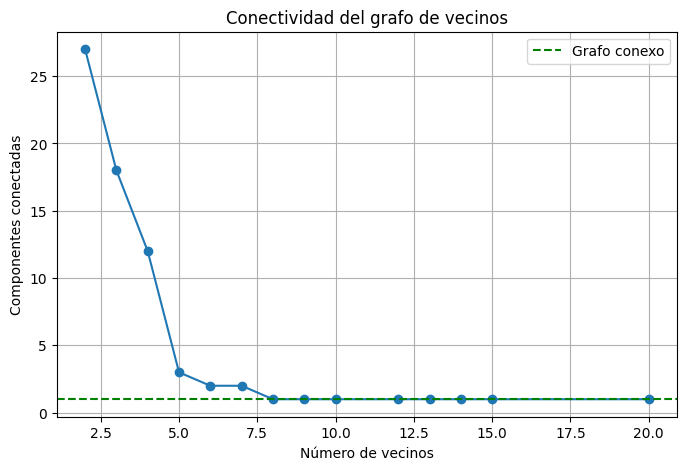

In [15]:
analizar_conectividad_grafo(X_train, vecinos_prueba=[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 20])


## **Grid search de hiperparámetros óptimos para ISOMAP**

Se lleva a cabo una búsqueda sistemática de los mejores hiperparámetros para el algoritmo ISOMAP, específicamente el número de vecinos (n_neighbors) y la cantidad de componentes (n_components) a conservar. Para cada combinación posible, se aplica ISOMAP sobre los datos de train y se entrena una red neuronal simple (MLP) de la librería sklearn, con el conjunto reducido. Luego, se evalúa el desempeño sobre un conjunto de validación, calculando la precisión obtenida. Finalmente, se seleccionan los valores que logran la mayor precisión y se visualizan los resultados en un mapa de calor, lo que permite identificar fácilmente la configuración más eficaz para aplicar en el modelo final.

In [28]:
def grid_search_isomap(
    X, y,
    n_neighbors_list=[8, 9, 10, 12, 15, 20],
    n_components_list=[10, 15, 20, 25, 30, 35, 40, 50, 60, 70],
    k_folds=5,
    random_state=42,
    guardar_csv=False,
    nombre_csv="resultados_isomap_cv.csv"
):
    """
    Realiza búsqueda de hiperparámetros para ISOMAP usando validación cruzada y MLP.

    Parámetros:
    -----------
    X : array-like (n_samples, n_features)
    y : array-like (n_samples,)
    n_neighbors_list : lista de vecinos a probar
    n_components_list : lista de componentes a probar
    k_folds : cantidad de folds para cross-validation
    guardar_csv : bool, si guardar resultados como CSV
    nombre_csv : nombre del archivo CSV a guardar

    Retorna:
    --------
    best_k : int
    best_n : int
    matriz_accuracy : matriz (len(n_neighbors), len(n_components)) con accuracies promedio
    """

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    resultados = np.zeros((len(n_neighbors_list), len(n_components_list)))
    tabla_resultados = []

    for i, k in enumerate(n_neighbors_list):
        for j, n in enumerate(n_components_list):
            acc_folds = []
            for train_idx, val_idx in skf.split(X, y):
                try:
                    X_train, X_val = X[train_idx], X[val_idx]
                    y_train, y_val = y[train_idx], y[val_idx]

                    # ⚠️ Estandarizar dentro del fold
                    scaler = StandardScaler()
                    X_train_std = scaler.fit_transform(X_train)
                    X_val_std = scaler.transform(X_val)

                    # ISOMAP
                    isomap = Isomap(n_neighbors=k, n_components=n)
                    X_train_iso = isomap.fit_transform(X_train_std)
                    X_val_iso = isomap.transform(X_val_std)

                    # MLP
                    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=random_state)
                    mlp.fit(X_train_iso, y_train)
                    y_val_pred = mlp.predict(X_val_iso)
                    acc = accuracy_score(y_val, y_val_pred)
                    acc_folds.append(acc)
                except Exception as e:
                    print(f"Error con vecinos={k}, componentes={n}: {e}")
                    acc_folds.append(0.0)

            acc_promedio = np.mean(acc_folds)
            resultados[i, j] = acc_promedio
            tabla_resultados.append({"vecinos": k, "componentes": n, "accuracy_promedio": acc_promedio})

    # Mejor combinación
    best_idx = np.unravel_index(np.argmax(resultados), resultados.shape)
    best_k = n_neighbors_list[best_idx[0]]
    best_n = n_components_list[best_idx[1]]
    best_acc = resultados[best_idx]

    # Visualización
    plt.figure(figsize=(10, 8))
    sns.heatmap(resultados, annot=True, fmt=".3f",
                xticklabels=n_components_list, yticklabels=n_neighbors_list, cmap="viridis")
    plt.xlabel("n_components")
    plt.ylabel("n_neighbors")
    plt.title(f"Accuracy promedio (CV {k_folds}-folds) - ISOMAP + MLP")
    plt.show()

    print(f"\n Mejor combinación encontrada:")
    print(f" - n_neighbors = {best_k}")
    print(f" - n_components = {best_n}")
    print(f" - Accuracy promedio = {best_acc:.4f}")

    if guardar_csv:
        df = pd.DataFrame(tabla_resultados)
        df.to_csv(nombre_csv, index=False)
        print(f"Resultados guardados en {nombre_csv}")

    return best_k, best_n, resultados

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint

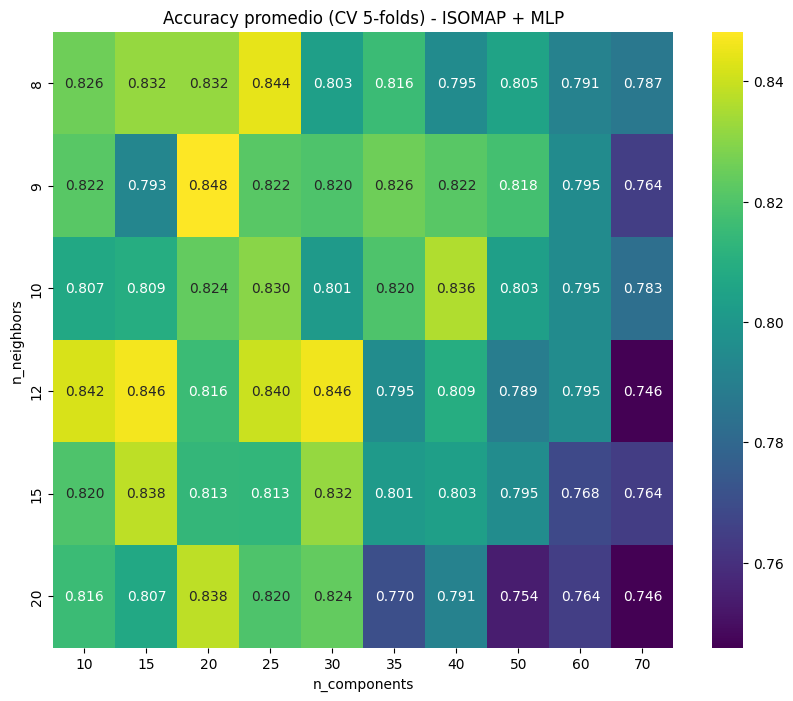


 Mejor combinación encontrada:
 - n_neighbors = 9
 - n_components = 20
 - Accuracy promedio = 0.8482
Resultados guardados en resultados_isomap_cv.csv


In [29]:
best_k, best_n, acc_matrix = grid_search_isomap(X_train, y_train, k_folds=5, guardar_csv=True)

## **Estandarización de los datos antes de aplicar ISOMAP**

In [18]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Guardamos scaler
with open(os.path.join(ruta_salida, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

## **Aplicación de ISOMAP con parámetros optimizados**

Se aplica ISOMAP utilizando los valores óptimos de hiperparámetros seleccionados previamente (n_neighbors = 9, n_components = 20). Primero se ajusta el modelo con el conjunto de entrenamiento para aprender la estructura no lineal de los datos, y luego se transforma el conjunto de prueba utilizando la misma proyección. De este modo, ambos subconjuntos quedan representados en un espacio de menor dimensión, conservando la relación entre las muestras y preparándolos para el entrenamiento del modelo de clasificación.

In [22]:
# vecinos a probar: [8, 9, 10, 12, 15] y componentes a probar: [10, 20, 25, 30, 35]
N_VECINOS = 9
N_COMPONENTES = 20


isomap = Isomap(n_neighbors = N_VECINOS, n_components = N_COMPONENTES)
X_train_iso = isomap.fit_transform(X_train_std)
X_test_iso = isomap.transform(X_test_std)

# Guardar modelo ISOMAP
with open(os.path.join(ruta_salida, "isomap_9_20.pkl"), "wb") as f:
    pickle.dump(isomap, f)

## **Visualización de la proyección ISOMAP por persona**

Se genera un gráfico bidimensional que muestra cómo se distribuyen las imágenes de cada persona en el espacio reducido obtenido mediante ISOMAP. Para ello, se recorren las distintas etiquetas del conjunto de entrenamiento y se representan sus proyecciones utilizando colores diferentes. Esta visualización permite observar de forma intuitiva cómo se agrupan o solapan las clases en el nuevo espacio. Si bien el gráfico muestra solo dos dimensiones, la reducción realizada por ISOMAP considera en realidad 20 dimensiones, por lo que esta es una representación parcial de la estructura aprendida.

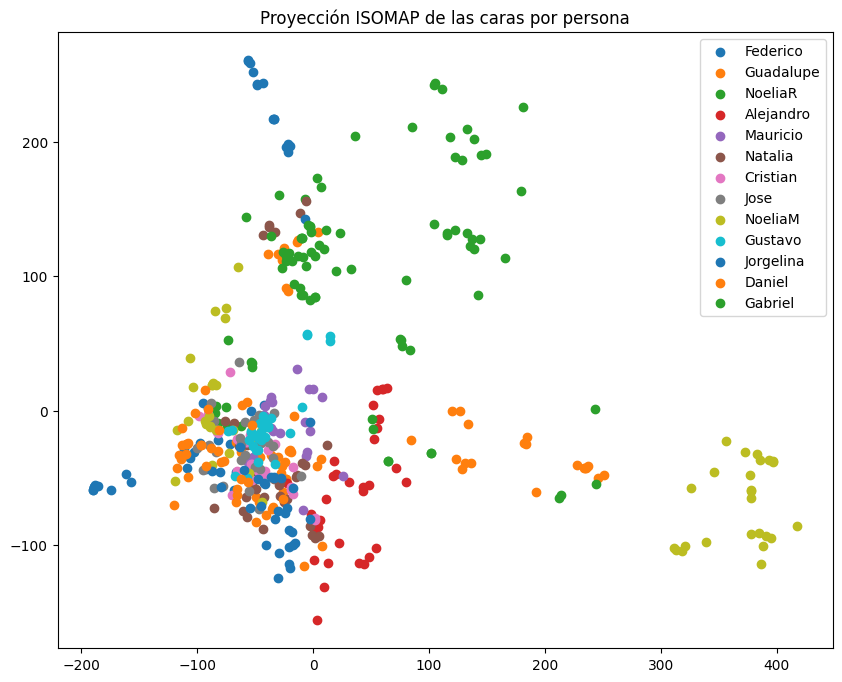

In [23]:
plt.figure(figsize=(10, 8))
for etiqueta in set(y_train):
    idxs = [i for i, e in enumerate(y_train) if e == etiqueta]
    plt.scatter(X_train_iso[idxs, 0], X_train_iso[idxs, 1], label=etiqueta)

plt.legend()
plt.title("Proyección ISOMAP de las caras por persona")
plt.show()

## **Construcción del DataFrame de train y test y lo guardamos en el disco**

Se organiza la información del conjunto de entrenamiento y de test, cada uno en un DataFrame. Primero se generan nombres de columna (x1 a x20) para cada componente resultante de la proyección ISOMAP. Luego, se crea un DataFrame con esas variables y se incorpora la columna de etiquetas (y) correspondiente a cada muestra. Este nuevo DataFrame de entrenamiento, estructurado y etiquetado, será utilizado como entrada para entrenar el modelo de clasificación y el dataframe de test sera utilizado para probar el desempeño del modelo.

In [24]:
column_names = [f"x{i+1}" for i in range(X_train_iso.shape[1])]

df_train = pl.DataFrame(X_train_iso, schema=column_names).with_columns(
    pl.Series("y", y_train)
)

df_test = pl.DataFrame(X_test_iso, schema=column_names).with_columns(
    pl.Series("y", y_test)
)

with open(os.path.join(ruta_salida, "isomap_train.pkl"), "wb") as f:
    pickle.dump(df_train, f)

with open(os.path.join(ruta_salida, "isomap_test.pkl"), "wb") as f:
    pickle.dump(df_test, f)

## Explorar algunos nombres de fotos quedaron en entrenamiento

In [25]:
# Mostrar los primeros archivos
for nombre in fn_train[:10]:
    print(nombre)

IMG_1549.JPG
730c133b-d6ac-4537-9ec3-050016dcf3f9.JPG
IMG_1105.JPG
IMG_8260.JPG
IMG_1065.JPG
IMG_1106.JPG
IMG_20250321_140744163.jpg
IMG_20250321_140535510_HDR.jpg
1742907849847.jpg
IMG_8688.jpeg
